# Adduct Detection

In mass spectrometry it is crucial to ionize analytes prior to
detection, because they are accelerated and manipulated in electric
fields, allowing their separation based on mass-to-charge ratio. This
happens by addition of protons in positive mode or loss of protons in
negative mode. Other ions present in the buffer solution can ionize the
analyte as well, e.g. sodium, potassium or formic acid. Depending on the
size and chemical compsition, multiple adducts can bind leading to
multiple charges on the analyte. In metabolomics with smaller analytes
the number of charges is typically low with one or two, whereas in
proteomics the number of charges is potentially higher.

Furthermore, analytes can loose functional groups during ionization,
e.g. a neutral water loss. Since the ionization happens after liquid
chromatography, different adducts for an analyte have almost identical
retention times.

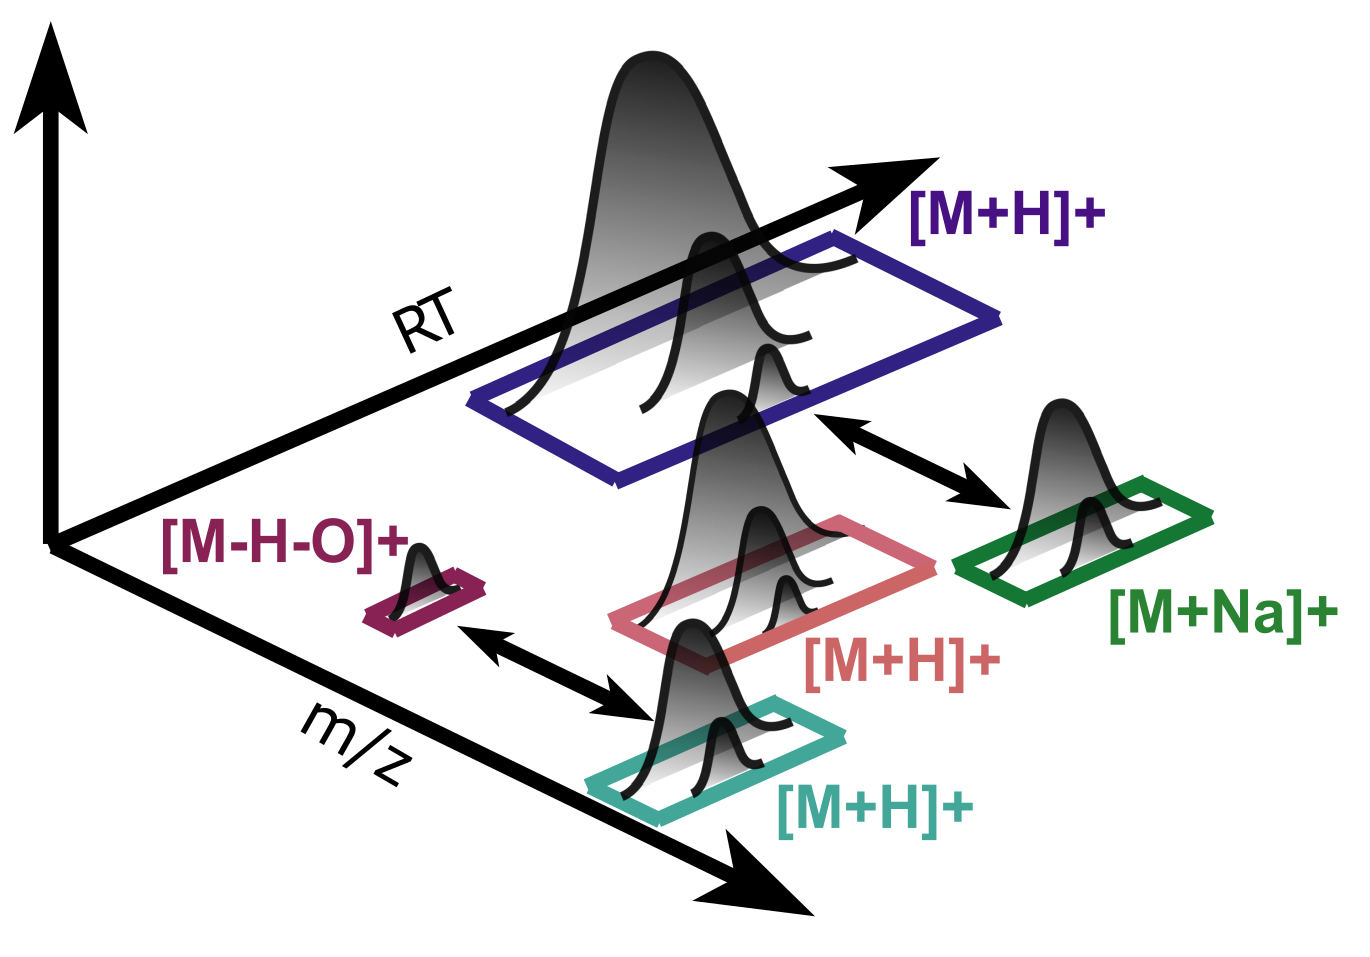

In pyOpenMS,
[MetaboliteFeatureDeconvolution](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MetaboliteFeatureDeconvolution.html)
takes a
[feature map](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-map)
as input adding adduct information as additional meta values. Features
belonging to an adduct group will be stored in a
[consensus map](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-consensus-map).
The most important parameters are explained in the comments.

**Input file generation:**  
The input
[feature map](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-map)
can be obtained using a [feature finder
algorithm](feature_detection.ipynb).

**Suggested follow up step:**  
The resulting feature map can be exported to a pandas DataFrame with
adduct information from the *dc_charge_adducts* feature meta values.  
Multiple
[feature maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-maps)
can be [combined using the feature linking
algorithms](feature_linking.ipynb). Each consensus feature will get a
new meta value *best ion* based on the most common annotated adduct
within the consensus feature group.

In [ ]:
from urllib.request import urlretrieve
import pyopenms as poms

# get example data file with metabolmics feature map
gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master"
urlretrieve(gh + "/src/data/MetaboliteFeatureDeconvolution_input.featureXML", "example.featureXML")

# open example input feature map
feature_map = poms.FeatureMap()
poms.FeatureXMLFile().load("example.featureXML", feature_map)

# initialize MetaboliteFeatureDeconvolution
mfd = poms.MetaboliteFeatureDeconvolution()

# get default parameters
params = mfd.getDefaults()
# update/explain most important parameters

# adducts to expect: elements, charge and probability separated by colon
# the total probability of all charged adducts needs to be 1
# e.g. positive mode: 
# proton dduct "H:+:0.6", sodium adduct "Na:+:0.4" and neutral water loss "H-2O-1:0:0.2"
# e.g. negative mode:
# with neutral formic acid adduct: "H-1:-:1", "CH2O2:0:0.5"
# multiples don't need to be specified separately:
# e.g. [M+H2]2+ and double water loss will be detected as well!
# optionally, retention time shifts caused by adducts can be added
# e.g. a formic acid adduct causes 3 seconds earlier elution "CH2O2:0:0.5:-3"
params.setValue("potential_adducts", ["H:+:0.6", "Na:+:0.4", "H-2O-1:0:0.2"])

# expected charge range
# e.g. for positive mode metabolomics:
# minimum of 1, maximum of 3, maximum charge span for a single feature 3
# for negative mode:
# charge_min = -3, charge_max = -1
params.setValue("charge_min", 1, "Minimal possible charge")
params.setValue("charge_max", 3, "Maximal possible charge")
params.setValue("charge_span_max", 3)

# maximum RT difference between any two features for grouping
# maximum RT difference between between two co-features, after adduct shifts have been accounted for 
# (if you do not have any adduct shifts, this value should be equal to "retention_max_diff")
params.setValue("retention_max_diff", 3.0)
params.setValue("retention_max_diff_local", 3.0)

# set updated paramters object
mfd.setParameters(params)

# result feature map: will store features with adduct information
feature_map_MFD = poms.FeatureMap()
# result consensus map: will store grouped features belonging to a charge group
groups = poms.ConsensusMap()
# result consensus map: will store paired features connected by an edge
edges = poms.ConsensusMap()

# compute adducts
mfd.compute(feature_map, feature_map_MFD, groups, edges)

# export feature map as pandas DataFrame and append adduct information
df = feature_map_MFD.get_df(export_peptide_identifications=False)
df["adduct"] = [f.getMetaValue("dc_charge_adducts") for f in feature_map_MFD]

# display data
print(df.head())